Import libraries

In [20]:
import pandas as pd
import numpy as np
import re
from pyvi.ViTokenizer import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU, Input
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Load data

In [21]:
TRAIN_DATA = '../data/ViHSD/train.csv'
DEV_DATA = '../data//ViHSD/dev.csv'
TEST_DATA = '../data/ViHSD/test.csv'

# read data
train_data = pd.read_csv(TRAIN_DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

train_data = train_data.dropna(subset=['free_text'])
dev_data = dev_data.dropna(subset=['free_text'])
test_data = test_data.dropna(subset=['free_text'])


print(len(train_data))
print(len(dev_data))
print(len(test_data))

24046
2672
6680


Data preprocessing

In [22]:
STOPWORDS = '../data/vietnamese-stopwords-dash.txt'
stopwords = []

with open(STOPWORDS, "r") as ins:
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    # remove emoji
    emoji_pattern = re.compile(
        pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0000200D"              # Zero Width Joiner
            u"\U0000200C"              # Zero Width Non-Joiner
            "]+", 
        flags = re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)  
    return text

def deSpecialCharacters(text):
    text =  re.sub('\W+',' ', text )
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = deEmojify(text)
    text = deSpecialCharacters(text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower() if lowercased else text
    # text = replace_teencode(text)
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)# text = filter_stop_words(text, stopwords)
    return text

In [23]:
train_data['free_text'] = train_data['free_text'].apply(preprocess)
test_data['free_text'] = train_data['free_text'].apply(preprocess)
dev_data['free_text'] = train_data['free_text'].apply(preprocess)
train_data = train_data[train_data['free_text'] != '']
test_data = test_data[test_data['free_text'] != '']
dev_data = dev_data[dev_data['free_text'] != '']

In [24]:
tr_text = train_data['free_text']
tr_label = train_data['label_id']

val_text = dev_data['free_text']
val_label = dev_data['label_id']

ts_text = test_data['free_text']
ts_label = test_data['label_id']

Feature

In [25]:
vocabulary_size = 10000
sequence_length = 100

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=sequence_length) 
tr_y = to_categorical(tr_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=sequence_length)
val_y = to_categorical(val_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=sequence_length)
ts_y = to_categorical(ts_label, num_classes=2)

note

Run model

In [26]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [27]:
input_shape = (max_len,)
# Branch 1
input1 = Input(shape=input_shape)
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

branch1_output = branch1(input1)

# Branch 2
input2 = Input(shape=input_shape)
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

branch2_output = branch2(input2)

# Concatenate branches
concatenated = Concatenate()([branch1_output, branch2_output])

# Add hidden and output layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

# Define the model
model = Model(inputs=[input1, input2], outputs=output_layer)

# Print model summary
model.summary()

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │    326,464 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64)        │    326,464 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ sequential_8[0][… │
│ (Concatenate)       │                   │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │        258 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │    326,464 │ input_layer_12[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64)        │    326,464 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 128)       │          0 │ sequential_8[0][… │
│ (Concatenate)       │                   │            │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 2)         │        258 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True,min_delta=0.001)
class_weights = {0: 1.0, 1: 3.0}

batch_size = 256
epochs = 25 # 40, 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    callbacks=[early_stopping],
                    class_weight=class_weights
                    )

Epoch 1/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9381 - loss: 0.2464 - precision_3: 0.9381 - recall_3: 0.9381 - val_accuracy: 0.7011 - val_loss: 1.0108 - val_precision_3: 0.7011 - val_recall_3: 0.7011
Epoch 2/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9438 - loss: 0.2239 - precision_3: 0.9438 - recall_3: 0.9438 - val_accuracy: 0.6870 - val_loss: 1.1777 - val_precision_3: 0.6870 - val_recall_3: 0.6870
Epoch 3/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9520 - loss: 0.1988 - precision_3: 0.9520 - recall_3: 0.9520 - val_accuracy: 0.6877 - val_loss: 1.2709 - val_precision_3: 0.6877 - val_recall_3: 0.6877
Epoch 4/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9569 - loss: 0.1766 - precision_3: 0.9569 - recall_3: 0.9569 - val_accuracy: 0.6950 - val_loss: 1.3543 - val_precision_3: 0.6950 - val_recall_3: 0.6950
Epoch 5/25
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9606 - loss: 0.1697 - precision_3: 0.9606 - recall_3: 0.9606 - val_

Save model

In [31]:
import pickle
with open('../models/tokenizer_cnn_hsd.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('../models/model_cnn_hsd.h5')

Evaluation and Visullize results

In [32]:
def evaluation(y_pred, y_test):
    # Tính toán các chỉ số đánh giá
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-micro: {f1_micro}")
    print(f"F1-macro: {f1_macro}")

[[4420 1012]
 [ 895  215]]
Accuracy: 0.7084989299908285
Precision: 0.5034163893150431
Recall: 0.5036951531796893
F1-micro: 0.7084989299908285
F1-macro: 0.503275854236262
None


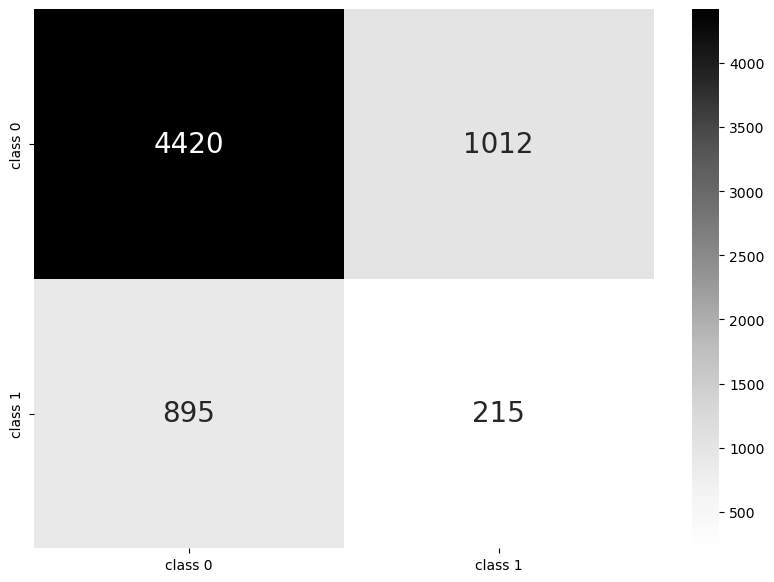

In [33]:
predictions = model.predict([ts_x, ts_x], batch_size=batch_size, verbose=0)
y_pred = predictions.argmax(axis=-1)
y_true = ts_label

# Tính toán confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

print(evaluation(y_pred, y_true))

# Vẽ confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=["class 0", "class 1"],
                     columns=["class 0", "class 1"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Greys", fmt='g', cbar=True, annot_kws={"size": 20})
plt.show()

In [34]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [36]:
input_shape = (max_len,)
# Branch 1
input1 = Input(shape=input_shape)
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

branch1_output = branch1(input1)

# Branch 2
input2 = Input(shape=input_shape)
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

branch2_output = branch2(input2)

# Concatenate branches
concatenated = Concatenate()([branch1_output, branch2_output])

# Add hidden and output layers
hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

# Define the model
model = Model(inputs=[input1, input2], outputs=output_layer)

model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 64)        │    326,464 │ input_layer_20[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │    326,464 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 128)       │          0 │ sequential_12[0]… │
│ (Concatenate)       │                   │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     16,512 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        258 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 669,698 (2.55 MB)

 Trainable params: 669,442 (2.55 MB)

 Non-trainable params: 256 (1.00 KB)

In [37]:
model.load_weights('../models/model_cnn_hsd.h5')